# WISE2MBH Tutorial: WXSC

This sample contain WISE data from the WXSC catalog. Distances, morphologies and photometric/physical quantities are provided. At the moment of calculating W1 absolute magnitude, the distance modulus is calculated from the provided distance.

In [1]:
import wise2mbh as wm
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import random
no_data = 9876543

Could not import regions, which is required for some of the functionalities of this module.


In [2]:
wxsc = Table.read('../samples/WXSC_sample.fit')
wxsc

Name,RAJ2000,DEJ2000,Morph,b_a,PA,R1,W1mag,e_W1mag,R2,W2mag,e_W2mag,R3,W3mag,e_W3mag,R4,W4mag,e_W4mag,Dist,Beam,W1-W2,l_W2-W3,W2-W3,LogLw1,e_LogLw1,LogMs,e_LogMs,l_LognuL3,LognuL3,l_LognuL4,LognuL4,l_SFR12,SFR12,l_SFR23,SFR23,l_sSFR12,sSFR12,RW1,AW1mag,e_AW1mag,RW2,AW2mag,e_AW2mag,RW3,AW3mag,e_AW3mag,RW4,AW4mag,e_AW4mag,TW1mag,e_TW1mag,TW2mag,e_TW2mag,TW3mag,e_TW3mag,TW4mag,e_TW4mag,SimbadName,NED,recno
,deg,deg,,,deg,arcmin,mag,mag,arcmin,mag,mag,arcmin,mag,mag,arcmin,mag,mag,Mpc,pc,mag,,mag,log(solLum),log(solLum),log(solMass),log(solMass),,log(solLum),,log(solLum),,solMass / yr,,solMass / yr,,1 / yr,arcmin,mag,mag,arcmin,mag,mag,arcmin,mag,mag,arcmin,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,
bytes11,float64,float64,bytes7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,bytes1,float64,float64,float64,float64,float64,bytes1,float64,bytes1,float64,bytes1,float64,bytes1,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes20,bytes3,int32
LMC,79.64101,-68.81836,SBm,1.0,0.0,300.0,-1.93,0.01,300.0,-1.99,0.01,300.0,-4.78,0.05,300.0,-7.15,0.05,0.05,1,0.06,,2.79,9.47,0.01,9.15,0.11,,7.62,,7.76,,0.12,,0.03,,-10.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LMC,NED,1
SMC,13.1866,-72.8286,SBm-pec,1.0,0.0,166.67,0.56,0.01,166.67,0.62,0.01,166.67,-0.93,0.01,166.67,-3.48,0.01,0.06,2,-0.05,,1.55,8.63,0.01,8.59,0.09,,6.06,,6.43,,0.01,,0.01,,-10.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SMC,NED,2
MESSIER31,10.68479,41.26907,Sb,0.35,37.3,111.44,0.08,0.01,111.44,0.13,0.01,111.44,-1.95,0.01,111.44,-3.09,0.01,0.77,22,-0.03,,2.09,11.04,0.02,10.95,0.14,,8.82,,8.48,,1.2,,0.58,,-10.88,149.39,0.08,0.01,132.78,0.13,0.01,148.8,-1.95,0.01,99.38,-3.11,0.01,0.06,0.01,0.1,0.01,-2.0,0.01,-3.13,0.01,MESSIER31,NED,3
MESSIER33,23.46204,30.66022,Sc,0.59,18.9,31.64,3.09,0.01,31.64,3.02,0.01,31.64,-0.17,0.01,31.64,-1.94,0.01,0.86,25,0.07,,3.18,9.97,0.02,9.61,0.14,,8.33,,8.22,,0.45,,0.33,,-9.96,65.32,3.03,0.01,38.83,3.0,0.01,37.28,-0.17,0.01,30.55,-1.94,0.01,3.08,0.01,3.02,0.01,-0.22,0.01,-2.02,0.01,MESSIER33,NED,4
NGC0253,11.88844,-25.28827,SABc,0.28,53.0,21.13,3.46,0.01,21.13,3.27,0.01,21.13,-0.54,0.04,21.13,-2.94,0.04,3.01,88,0.19,,3.83,10.88,0.01,10.24,0.09,,9.54,,9.64,,5.36,,6.52,,-9.51,25.27,3.46,0.01,24.39,3.26,0.01,25.13,-0.55,0.03,25.33,-2.94,0.03,3.46,0.01,3.25,0.01,-0.56,0.03,-2.95,0.03,NGC0253,NED,5
NGC5128,201.36481,-43.01954,S0,0.77,33.8,19.64,3.01,0.01,19.64,2.98,0.01,19.64,0.45,0.01,19.64,-1.25,0.01,3.65,106,0.01,,2.55,11.23,0.01,11.02,0.09,,9.25,,9.12,,2.98,,2.16,,-10.55,23.45,2.99,0.01,23.36,2.98,0.01,9.08,0.41,0.01,8.32,-1.29,0.01,2.98,0.01,2.97,0.01,0.44,0.01,-1.26,0.01,NGC5128,NED,6
NGC0055,3.72192,-39.19775,SBm,0.19,108.9,19.49,5.45,0.01,19.49,5.36,0.01,19.49,2.8,0.01,19.49,0.29,0.01,2.1,61,0.09,,2.66,9.77,0.01,9.39,0.09,,7.88,,8.06,,0.19,,0.23,,-10.11,23.36,5.42,0.01,23.31,5.33,0.01,18.76,2.8,0.01,18.66,0.29,0.01,5.43,0.01,5.3,0.02,2.7,0.03,0.22,0.02,NGC0055,NED,7
MESSIER81,148.88837,69.06528,Sab,0.56,156.7,14.67,3.6,0.01,14.67,3.61,0.01,14.67,1.84,0.03,14.67,0.45,0.03,3.65,106,-0.01,,1.81,10.99,0.01,10.85,0.09,,8.62,,8.44,,0.82,,0.52,,-10.94,16.57,3.6,0.01,16.97,3.6,0.01,10.34,1.82,0.03,10.61,0.44,0.03,3.6,0.01,3.59,0.01,1.79,0.03,0.35,0.03,MESSIER81,NED,8


# Morphology cleaning process

For this sample, LMC & SMC, irregulars (IB, IBm) and very-late type (Sm) must be dropped due to possible miscalculation in bulge fraction from their morphology. For that we defineed the function drop_irregular() to 

In [3]:
def drop_irregulars(strings):
    def criteria(string):
        for i in range(len(string)-1):
            if ((string[i].isupper()) and (string[i + 1] == 'm')) | (string[0]=='I'):
                return False
        return True
    boolean_array = [criteria(string) for string in strings]
    return np.array(boolean_array)

In [4]:
drop_boolean = drop_irregulars(wxsc['Morph'])
wxsc_no_irr = wxsc[drop_boolean]

In [5]:
np.unique(wxsc_no_irr['Morph'])

E
E-S0
E1pec
S0
S0-a
S?
SABa
SABb
SABc
SABcd
SAd


In [6]:
def keep_first_and_non_capitals(strings):
    def criteria(string):
        result = string[0]  # Initialize the result with the first letter

        # Iterate through the remaining characters in the string
        for char in string[1:]:
            if char.islower() or not char.isalpha():
                result += char

        return result.strip()
    output = [criteria(s) for s in input_strings]
    return np.array(output)

# Test the function with a list of strings
input_strings = wxsc_no_irr['Morph']
output = keep_first_and_non_capitals(input_strings)

np.unique(output)

array(['E', 'E-0', 'E1pec', 'S0', 'S0-a', 'S?', 'Sa', 'Sab', 'Sb', 'Sbc',
       'Sc', 'Scd', 'Sd', 'Sdm', 'Z'], dtype='<U5')

For sources with E1pec, we will assume an E morphology. For both S? and Z, the morphology will be estimated using the color of presented in WXSC. This sample is local, so no K-corrections will be applied.

In [7]:
morph_tags = ['E', 'E-0', 'E1pec', 'S0', 'S0-a', 'S?', 'Sa', 'Sab', 'Sb', 'Sbc', 'Sc', 'Scd', 'Sd', 'Sdm', 'Z']
morph_T = [-5,-4,-5,-2,0,-99,1,2,3,4,5,6,7,8,-99]

morph_transform = {key: value for key, value in zip(morph_tags, morph_T)}

In [8]:
t_values = np.array([morph_transform[key] for key in output])
wxsc_to_change = wxsc_no_irr[(output=='S?') | (output=='Z')]

t_value_change = wm.w2w3_to_morph(wxsc_to_change['W2-W3'])

t_values[t_values==-99] = t_value_change
t_values

array([ 3,  5,  5, -2,  2,  5,  5,  6, -2, -5, -5, -4, -5,  1,  5,  5,  4,
       -5,  3,  6,  1,  3,  5, -5,  4,  4, -2, -5,  8,  3,  4,  6, -5, -5,
       -5, -5,  3, -4, -5, -5,  6, -5, -5,  5, -5,  5,  0,  3, -5,  3,  3,
        0,  5, -2, -2,  5, -5,  3,  1,  3,  4, -5,  1, -5,  3,  3,  6,  1,
       -4,  4,  1, -5, -5,  8,  7,  3,  2,  1,  1,  3,  6, -5,  3,  3,  5,
        3,  5, -5,  6,  0,  5, -5])

In [9]:
wxsc_no_irr['T'] = t_values
wxsc_no_irr

Name,RAJ2000,DEJ2000,Morph,b_a,PA,R1,W1mag,e_W1mag,R2,W2mag,e_W2mag,R3,W3mag,e_W3mag,R4,W4mag,e_W4mag,Dist,Beam,W1-W2,l_W2-W3,W2-W3,LogLw1,e_LogLw1,LogMs,e_LogMs,l_LognuL3,LognuL3,l_LognuL4,LognuL4,l_SFR12,SFR12,l_SFR23,SFR23,l_sSFR12,sSFR12,RW1,AW1mag,e_AW1mag,RW2,AW2mag,e_AW2mag,RW3,AW3mag,e_AW3mag,RW4,AW4mag,e_AW4mag,TW1mag,e_TW1mag,TW2mag,e_TW2mag,TW3mag,e_TW3mag,TW4mag,e_TW4mag,SimbadName,NED,recno,T
,deg,deg,,,deg,arcmin,mag,mag,arcmin,mag,mag,arcmin,mag,mag,arcmin,mag,mag,Mpc,pc,mag,,mag,log(solLum),log(solLum),log(solMass),log(solMass),,log(solLum),,log(solLum),,solMass / yr,,solMass / yr,,1 / yr,arcmin,mag,mag,arcmin,mag,mag,arcmin,mag,mag,arcmin,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,
bytes11,float64,float64,bytes7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,bytes1,float64,float64,float64,float64,float64,bytes1,float64,bytes1,float64,bytes1,float64,bytes1,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes20,bytes3,int32,int64
MESSIER31,10.68479,41.26907,Sb,0.35,37.3,111.44,0.08,0.01,111.44,0.13,0.01,111.44,-1.95,0.01,111.44,-3.09,0.01,0.77,22,-0.03,,2.09,11.04,0.02,10.95,0.14,,8.82,,8.48,,1.2,,0.58,,-10.88,149.39,0.08,0.01,132.78,0.13,0.01,148.8,-1.95,0.01,99.38,-3.11,0.01,0.06,0.01,0.1,0.01,-2.0,0.01,-3.13,0.01,MESSIER31,NED,3,3
MESSIER33,23.46204,30.66022,Sc,0.59,18.9,31.64,3.09,0.01,31.64,3.02,0.01,31.64,-0.17,0.01,31.64,-1.94,0.01,0.86,25,0.07,,3.18,9.97,0.02,9.61,0.14,,8.33,,8.22,,0.45,,0.33,,-9.96,65.32,3.03,0.01,38.83,3.0,0.01,37.28,-0.17,0.01,30.55,-1.94,0.01,3.08,0.01,3.02,0.01,-0.22,0.01,-2.02,0.01,MESSIER33,NED,4,5
NGC0253,11.88844,-25.28827,SABc,0.28,53.0,21.13,3.46,0.01,21.13,3.27,0.01,21.13,-0.54,0.04,21.13,-2.94,0.04,3.01,88,0.19,,3.83,10.88,0.01,10.24,0.09,,9.54,,9.64,,5.36,,6.52,,-9.51,25.27,3.46,0.01,24.39,3.26,0.01,25.13,-0.55,0.03,25.33,-2.94,0.03,3.46,0.01,3.25,0.01,-0.56,0.03,-2.95,0.03,NGC0253,NED,5,5
NGC5128,201.36481,-43.01954,S0,0.77,33.8,19.64,3.01,0.01,19.64,2.98,0.01,19.64,0.45,0.01,19.64,-1.25,0.01,3.65,106,0.01,,2.55,11.23,0.01,11.02,0.09,,9.25,,9.12,,2.98,,2.16,,-10.55,23.45,2.99,0.01,23.36,2.98,0.01,9.08,0.41,0.01,8.32,-1.29,0.01,2.98,0.01,2.97,0.01,0.44,0.01,-1.26,0.01,NGC5128,NED,6,-2
MESSIER81,148.88837,69.06528,Sab,0.56,156.7,14.67,3.6,0.01,14.67,3.61,0.01,14.67,1.84,0.03,14.67,0.45,0.03,3.65,106,-0.01,,1.81,10.99,0.01,10.85,0.09,,8.62,,8.44,,0.82,,0.52,,-10.94,16.57,3.6,0.01,16.97,3.6,0.01,10.34,1.82,0.03,10.61,0.44,0.03,3.6,0.01,3.59,0.01,1.79,0.03,0.35,0.03,MESSIER81,NED,8,2
MESSIER101,210.80225,54.34893,SABc,0.92,33.3,14.5,5.22,0.01,14.5,5.1,0.01,14.5,1.62,0.01,14.5,-0.28,0.01,7.22,210,0.12,,3.54,10.91,0.01,10.45,0.1,,9.43,,9.36,,4.22,,3.61,,-9.82,13.01,5.22,0.01,13.62,5.1,0.01,10.38,1.61,0.01,10.28,-0.3,0.01,5.19,0.01,5.03,0.02,1.56,0.02,-0.38,0.02,MESSIER101,NED,9,5
NGC4945,196.36409,-49.46816,SBc,0.37,43.4,12.98,4.07,0.01,12.98,3.87,0.01,12.98,0.31,0.01,12.98,-1.56,0.01,3.22,94,0.18,,3.57,10.71,0.01,10.07,0.09,,9.26,,9.15,,3.03,,2.31,,-9.59,15.49,4.06,0.01,14.72,3.87,0.01,12.76,0.31,0.01,13.7,-1.57,0.01,4.06,0.01,3.86,0.01,0.3,0.01,-1.58,0.01,NGC4945,NED,10,5
IC0342,56.70144,68.09635,SABcd,0.95,75.5,12.98,3.97,0.01,12.98,3.89,0.01,12.98,0.23,0.01,12.98,-1.81,0.01,3.14,91,0.05,,3.8,10.74,0.01,10.43,0.09,,9.33,,9.23,,3.49,,2.75,,-9.88,15.48,3.95,0.01,15.42,3.88,0.01,11.4,0.22,0.01,10.96,-1.83,0.01,3.93,0.01,3.85,0.01,0.09,0.03,-1.84,0.01,IC0342,NED,11,6


# Create MC arrays and start process

Now we will use the WISE cataloged data to estimate MBH. In this case, logSM will be compared to the one provided by the authors, but one can skip that first step and directly use logSM.

In [10]:
w1_mc = wm.array_montecarlo(wxsc_no_irr['W1mag'], wxsc_no_irr['e_W1mag'])
w2_mc = wm.array_montecarlo(wxsc_no_irr['W2mag'], wxsc_no_irr['e_W2mag'])

In [11]:
w1w2 = w1_mc - w2_mc
w1_abs = w1_mc - wm.distance_modulus_dist(wxsc_no_irr['Dist'])[:,None]

In [12]:
log_sm = wm.wise_to_logsm(w1_abs, w1w2, resolved=True)

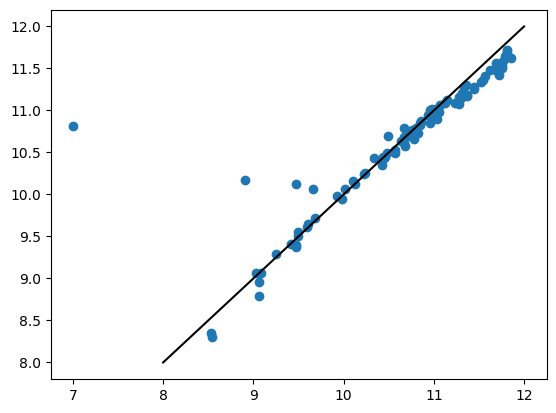

In [13]:
plt.scatter(np.median(log_sm, axis=1), wxsc_no_irr['LogMs'])
plt.plot([8,12],[8,12], c='k')

Some values are clearly different from ones provided by the author due to possible differences in the methods used, but overall, both estimates are in good agreement. Now we will proced with logSM calculated by the magnitudes, but an array montecarlo of the original values can be used as follows:

In [14]:
#log_sm = wm.array_montecarlo(wxsc_no_irr['LogMs'], wxsc_no_irr['e_LogMs'])

Similar to the AllWISE tutorial, the process now consist of obtaining BT, apply it to logSM to obtain logBM, then obtain logMBH, apply scatter and finally apply Cf to obtain the final MBH estimates.

In [15]:
bt = wm.morph_to_bulge_ratio(wxsc_no_irr['T'])

log_bm = np.log10(bt)[:,None] + log_sm

log_mbh_first = wm.bulge_to_mbh(log_bm, mc=True)

log_mbh_final = wm.comp_mbh(log_mbh_first)

7.777230463780684 8.3456760606182 8.897142807001531


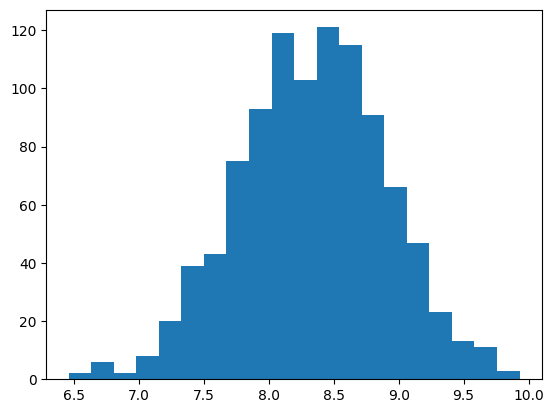

In [19]:
plt.hist(log_mbh_final[0], bins=20)
print(np.percentile(log_mbh_final[0],16),np.median(log_mbh_final[0]),np.percentile(log_mbh_final[0],84))

**Now all desire quantities can be stored into the table and saved to a FITS file!**

In [23]:
wxsc_no_irr['logSM_W2M'] = np.median(log_sm, axis=1)
wxsc_no_irr['logBM_W2M'] = np.median(log_bm, axis=1)
wxsc_no_irr['logMBH_W2M'] = np.median(log_mbh_final, axis=1)

In [ ]:
#wxsc_no_irr.write('enter_your_route_here.fits')